# Lab Session: Face Recognition

This notebook will go through how we can test the state-of-the-art ArcFace [1] recognition network with ResNet50 backbone on Labeled Faces in the Wild (LFW) benchmark dataset [2]. Provided codes are simplified version of [3] and [4].

[1] J. Deng et al., "ArcFace: Additive Angular Margin Loss for Deep Face Recognition," CVPR 2019.

[2] G. Huang et al., "Labeled Faces in the Wild: A Database for Studying Face Recognition in Unconstrained Environments," Technical report 2007.

[3] https://github.com/auroua/InsightFace_TF

[4] https://github.com/deepinsight/insightface

## Download datasets and models

Download train/test datasets and pre-trained models from "FaceRecognition.zip" in

https://www.dropbox.com/sh/b5yhp0gz8k31qlw/AAAScfQQbIV0ZFArjF-PvZ65a?dl=0

and extract the files in the current directory.

# Import necessary libraries

In [1]:
import os
import os.path
import time
from glob import glob
from matplotlib import pyplot as plt 
import imageio

import tensorflow as tf
import numpy as np

from sklearn.model_selection import KFold
import sklearn

import h5py

from utils import parse_function
from model import *
from pretrained.ArcFaceRecognizer import *

from loss import arcface_loss
from verification import ver_test

%reload_ext autoreload
%autoreload 2

# Implement the inference pipeline

We first get a grasp on how face recognition works, we will first load a trained network, and implement a few components in the inference pipeline.

### Load the trained model

First load the trained model.

In [2]:
model_dir = "./ckpt/ArcFace_iter_10000.ckpt"
tf.reset_default_graph()
net = ArcFaceRecognizer(model_dir)

INFO:tensorflow:Restoring parameters from ./ckpt/ArcFace_iter_10000.ckpt


## Calculate feature distances between two faces

Face verification works by comparing the distance between the feature vectors (extracted by DNN) of the pair of input faces against a threshold. 

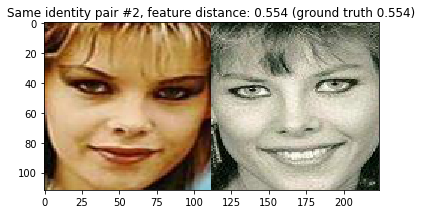

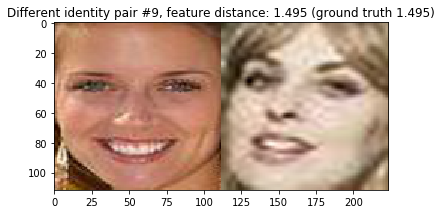

In [3]:
img_dir = "./samples"

def calc_distance(feature1, feature2):
    feature1 /= np.linalg.norm(feature1)
    feature2 /= np.linalg.norm(feature2)
    distance = np.sum(np.square(feature1-feature2))
    return distance

#answers
dist_same = [0.53376675, 1.3267114, 0.55421597, 0.78794116, 0.31515366, 0.751205, 0.41858816, 0.40230948, 0.812325, 0.5838026]
dist_diff = [2.1641526, 1.2850112, 1.2226313, 1.5683941, 1.2008921, 1.727424, 1.5676637, 2.1116953, 1.8701112, 1.4952464]

idx = np.random.randint(10)
img1 = imageio.imread(os.path.join(img_dir,"same1-%d.png"%idx))
img2 = imageio.imread(os.path.join(img_dir,"same2-%d.png"%idx))

feature1 = net.extract_feature(img1)
feature2 = net.extract_feature(img2)

distance = calc_distance(feature1, feature2)

plt.figure()
plt.imshow(np.concatenate([img1, img2], axis = 1))
title = "Same identity pair #%d, feature distance: %.3f (ground truth %.3f)"%(idx, distance, dist_same[idx])
plt.title(title)
plt.show()

idx = np.random.randint(10)
img1 = imageio.imread(os.path.join(img_dir,"diff1-%d.png"%idx))
img2 = imageio.imread(os.path.join(img_dir,"diff2-%d.png"%idx))


feature1 = net.extract_feature(img1)
feature2 = net.extract_feature(img2)

distance = calc_distance(feature1, feature2)

plt.figure()
plt.imshow(np.concatenate([img1, img2], axis = 1))
title = "Different identity pair #%d, feature distance: %.3f (ground truth %.3f)"%(idx, distance, dist_diff[idx])
plt.title(title)
plt.show()

## Evaluation on LFW dataset

Now, we implement the evaluation for LFW dataset.

### Load dataset

In [4]:
LFW = h5py.File("LFW.hdf5", "r+")
faces = LFW["imgs"]
labels = LFW["labels"]
labels = np.asarray(labels)

### Dataset exploration

Provided dataset contains 500 pairs of faces, each marked with a label indicating whether the two faces are the same person. Randomly pick an index, and see how the faces in the dataset looks like.

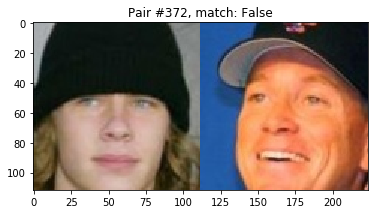

In [5]:
idx = np.random.randint(labels.shape[0])
img1 = faces[2*idx]
img2 = faces[2*idx+1]
match = labels[idx]
plt.figure()
plt.imshow(np.concatenate([img1, img2], axis = 1))
title = "Pair #%d, match: %r"%(idx, match)
plt.title(title)
plt.show()

### Process the dataset and calculate feature distances

Extract features of the faces and calculate feature distances

In [6]:
print("Start inference....")
time_consumed = 0.0

embeddings = None
batch_size = 32

def data_iter(datasets, batch_size):
    data_num = datasets.shape[0]
    for i in range(0, data_num, batch_size):
        yield datasets[i:min(i+batch_size, data_num), ...]

for idx, data in enumerate(data_iter(faces, batch_size)):
    time0 = time.time()
    _embeddings = net.extract_feature_batch(data)
    time_now = time.time()
    diff = time_now - time0
    time_consumed += diff
    if embeddings is None:
        embeddings = np.zeros((faces.shape[0], _embeddings.shape[1]))

    embeddings[idx*batch_size:min((idx+1)*batch_size, faces.shape[0]), ...] = _embeddings
    
embeddings = sklearn.preprocessing.normalize(embeddings)

embeddings1 = embeddings[0::2]
embeddings2 = embeddings[1::2]

diff = np.subtract(embeddings1, embeddings2)
dist = np.sum(np.square(diff), 1)

print('Inference finished! Test time: %.4f s' %(time_consumed))

Start inference....
Inference finished! Test time: 1.5042 s


### Plot ROC curve

[]

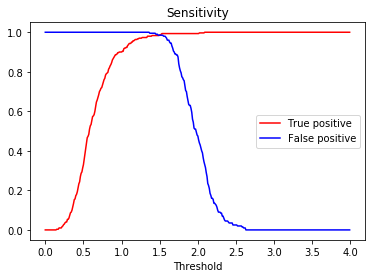

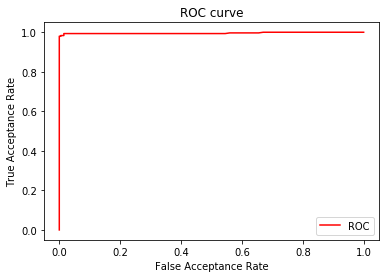

In [7]:
thresholds = np.arange(0, 4, 0.01)

def calculate_accuracy(threshold, dist, actual_issame):
    predict_issame = np.less(dist, threshold)
    
    tp = np.sum(np.logical_and(predict_issame, actual_issame))
    fp = np.sum(np.logical_and(predict_issame, np.logical_not(actual_issame)))
    tn = np.sum(np.logical_and(np.logical_not(predict_issame), np.logical_not(actual_issame)))
    fn = np.sum(np.logical_and(np.logical_not(predict_issame), actual_issame))

    tpr = 0 if (tp + fn == 0) else float(tp) / float(tp + fn)
    fpr = 0 if (fp + tn == 0) else float(fp) / float(fp + tn)
    acc = float(tp + tn) / dist.size
    return tpr, fpr, acc

tpr = np.zeros((len(thresholds)))
fpr = np.zeros((len(thresholds)))
for threshold_idx, threshold in enumerate(thresholds):
    tpr[threshold_idx], fpr[threshold_idx], _ = calculate_accuracy(threshold, dist, labels)
    
fig = plt.figure()
plt.plot(thresholds, tpr, color = 'r', label = 'True positive')
plt.plot(thresholds, 1-fpr, color = 'b', label = 'False positive')
plt.xlabel("Threshold")
_title = "Sensitivity"
plt.title(_title)
plt.legend()
plt.plot()

fig = plt.figure()
plt.plot(fpr, tpr, color = 'r', label = 'ROC')
plt.xlabel("False Acceptance Rate")
plt.ylabel("True Acceptance Rate")
_title = "ROC curve"
plt.title(_title)
plt.legend()
plt.plot()

### Calculate accuracy

In [9]:
folds = 10

nrof_pairs = min(len(labels), embeddings1.shape[0])
nrof_thresholds = len(thresholds)
k_fold = KFold(n_splits=folds, shuffle=False)

accuracy = np.zeros((folds))
indices = np.arange(nrof_pairs)

for fold_idx, (train_set, test_set) in enumerate(k_fold.split(indices)):
    # Find the best threshold for the fold
    acc_train = np.zeros((nrof_thresholds))
    for threshold_idx, threshold in enumerate(thresholds):
        _, _, acc_train[threshold_idx] = calculate_accuracy(threshold, dist[train_set], labels[train_set])
    best_threshold_index = np.argmax(acc_train)
    print('best threshold for fold %d: %.2f (test fold accuracy %.4f)' 
          %(fold_idx, thresholds[best_threshold_index], acc_train[best_threshold_index]))

    _, _, accuracy[fold_idx] = calculate_accuracy(thresholds[best_threshold_index], 
                                                  dist[test_set], labels[test_set])
    
acc, std = np.mean(accuracy), np.std(accuracy)
print('Accuracy: %1.4f+-%1.4f' % (acc, std))

best threshold for fold 0: 1.53 (test fold accuracy 0.9889)
best threshold for fold 1: 1.53 (test fold accuracy 0.9933)
best threshold for fold 2: 1.53 (test fold accuracy 0.9889)
best threshold for fold 3: 1.34 (test fold accuracy 0.9933)
best threshold for fold 4: 1.34 (test fold accuracy 0.9889)
best threshold for fold 5: 1.53 (test fold accuracy 0.9889)
best threshold for fold 6: 1.53 (test fold accuracy 0.9933)
best threshold for fold 7: 1.53 (test fold accuracy 0.9889)
best threshold for fold 8: 1.53 (test fold accuracy 0.9889)
best threshold for fold 9: 1.53 (test fold accuracy 0.9911)
Accuracy: 0.9820+-0.0209


# Training process

Below code shows the simplified version of how to train the ArcFace network. For full scale training, refer to the original repos [3,4]

In [11]:
tf.reset_default_graph()

# 1 dataset preparation
print("prepare datasets...")
# 1.1 load train dataset and prepare train dataloader
batch_size = 16
dataset = tf.data.TFRecordDataset('train.tfrecords')
dataset = dataset.map(parse_function)
dataset = dataset.shuffle(buffer_size=1000)
dataset = dataset.batch(batch_size)
iterator = dataset.make_initializable_iterator()
next_element = iterator.get_next()

# 1.2 load validation dataset
LFW = h5py.File("LFW.hdf5", "r+")
faces = LFW["imgs"]
_labels = LFW["labels"]
ver_list = [[[np.asarray(faces).astype(np.float32)[...,::-1]], _labels]]

# 2. training
# 2.1 build input/output nodes
with tf.variable_scope('resnet50', reuse=tf.AUTO_REUSE) as scope:
    global_step = tf.Variable(name='global_step', initial_value=0, trainable=False)
    inc_op = tf.assign_add(global_step, 1, name='increment_global_step')
    images = tf.placeholder(name='img_inputs', shape=[None, 112, 112, 3], dtype=tf.float32)
    labels = tf.placeholder(name='img_labels', shape=[None, ], dtype=tf.int64)
    dropout_rate = tf.placeholder(name='dropout_rate', dtype=tf.float32)

# 2.2 build model
print("build model...")
net = build_model(images, 50, trainable=True, keep_rate=dropout_rate)
test_net = build_model(images, 50, trainable=False, keep_rate=dropout_rate)
embedding_tensor = test_net

# 2.3 compute inference loss
logit = arcface_loss(embedding=net, labels=labels, out_num=85164)
inference_loss = tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(logits=logit, labels=labels))

# 2.4 define optimizer
with tf.variable_scope('resnet50', reuse=tf.AUTO_REUSE) as scope:
    opt = tf.train.AdamOptimizer(learning_rate=1e-4)

grads = opt.compute_gradients(inference_loss)
update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
with tf.variable_scope('resnet50', reuse=tf.AUTO_REUSE) as scope:
    with tf.control_dependencies(update_ops):
        train_op = opt.apply_gradients(grads, global_step=global_step)
        
# 2.5 begin training
print("start training...")
config = tf.ConfigProto(allow_soft_placement=True)
config.gpu_options.allow_growth = True
sess = tf.Session(config=config)
sess.run(tf.global_variables_initializer())
count = 0

sess.run(iterator.initializer)
for i in range(300):
    if count == 0:
        print('Start initial validation..')
        feed_dict_test ={dropout_rate: 1.0}
        results = ver_test(ver_list=ver_list, sess=sess,
                 embedding_tensor=embedding_tensor, feed_dict=feed_dict_test,
                 input_placeholder=images)

    images_train, labels_train = sess.run(next_element)
    feed_dict = {images: images_train, labels: labels_train, dropout_rate: 0.4}

    start = time.time()
    _, inference_loss_val, _ = \
        sess.run([train_op, inference_loss, inc_op], feed_dict=feed_dict)
    end = time.time()
    pre_sec = batch_size/(end - start)

    if count > 0 and count % 10 == 0:
        print('epoch %d, step %d, inference loss %.2f, training speed %.3f samples/sec' %
              (i, count, inference_loss_val, pre_sec))
    count += 1

    # validate
    if count > 0 and count % 50 == 0:
        print('Start validation..')
        feed_dict_test ={dropout_rate: 1.0}
        results = ver_test(ver_list=ver_list, sess=sess,
                 embedding_tensor=embedding_tensor, feed_dict=feed_dict_test,
                 input_placeholder=images)
print("Training done!")

prepare datasets...
build model...
start training...
Start initial validation..
Validation accuracy: 0.37800+-0.25945
epoch 10, step 10, inference loss 37.93, training speed 178.200 samples/sec
epoch 20, step 20, inference loss 32.71, training speed 178.642 samples/sec
epoch 30, step 30, inference loss 33.15, training speed 176.850 samples/sec
epoch 40, step 40, inference loss 29.50, training speed 175.793 samples/sec
Start validation..
Validation accuracy: 0.76400+-0.10423
epoch 50, step 50, inference loss 30.28, training speed 176.752 samples/sec
epoch 60, step 60, inference loss 24.23, training speed 160.017 samples/sec
epoch 70, step 70, inference loss 26.47, training speed 175.385 samples/sec
epoch 80, step 80, inference loss 27.10, training speed 175.641 samples/sec
epoch 90, step 90, inference loss 26.23, training speed 174.934 samples/sec
Start validation..
Validation accuracy: 0.72200+-0.08875
epoch 100, step 100, inference loss 28.18, training speed 174.599 samples/sec
epoch 